# Non-Functional Positioners

See [here](https://docs.google.com/spreadsheets/d/1e8yyjNFI9nCOT_KsJAxI3uzl8qSKqhuiDVXtXvxHNqM/edit#gid=0) for DB schemas.

See list of recent motor problems [here](https://desi.lbl.gov/trac/wiki/InstOpsPages/DisabledPositioners/BadPosOnset).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathlib import Path

In [3]:
import pandas as pd

In [4]:
import desietc.db

In [5]:
import fpoffline.const
from fpoffline.array import plotFP

In [6]:
DESI = Path('/global/cfs/cdirs/desi')
#DBCONFIG = DESI / 'engineering' / 'focalplane' / 'db.yaml'
#assert DBCONFIG.exists()
#DB = desietc.db.DB(config_name=DBCONFIG)

In [7]:
import fpoffline.db

In [8]:
DB = fpoffline.db.DB()

In [9]:
def get_nonfunctional(DB, at=None):
    """Get the current list of non-functional positioners (excluding ETC).
    """
    tables = []
    before = '' if at is None else f" where time_recorded<=TIMESTAMP '{pd.Timestamp(at)}'"
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        table_name = f'posmovedb.positioner_calibration_p{petal_id}'
        sql = f'''
            select pos_id,device_loc,time_recorded,gear_calib_t,gear_calib_p,classified_as_retracted,
                fiber_intact,device_classified_nonfunctional
            from {table_name}
            where (pos_id,time_recorded) in
            (
                select pos_id,max(time_recorded)
                from {table_name}{before}
                group by pos_id
            )'''
        table = DB.query(sql, 600)
        table = table[table.device_classified_nonfunctional]
        # Exclude ETC positioners
        table = table[~np.isin(table.device_loc,[461, 501])]        
        table['location'] = 1000*petal_loc + table['device_loc']
        table.drop(columns=['device_loc','device_classified_nonfunctional'], inplace=True)
        table.set_index('pos_id', verify_integrity=True, inplace=True)
        tables.append(table)
        print(f'Found {len(table)} non-functional positioners on petal loc[{petal_loc}] id[{petal_id}]')
    NonFunc = pd.concat(tables, axis='index', ignore_index=False)
    print(f'Found {len(NonFunc)} non-functional robots')
    return NonFunc

NonFunc = get_nonfunctional(DB)

Found 55 non-functional positioners on petal loc[0] id[4]
Found 97 non-functional positioners on petal loc[1] id[5]
Found 60 non-functional positioners on petal loc[2] id[6]
Found 94 non-functional positioners on petal loc[3] id[3]
Found 90 non-functional positioners on petal loc[4] id[8]
Found 69 non-functional positioners on petal loc[5] id[10]
Found 63 non-functional positioners on petal loc[6] id[11]
Found 124 non-functional positioners on petal loc[7] id[2]
Found 77 non-functional positioners on petal loc[8] id[7]
Found 62 non-functional positioners on petal loc[9] id[9]
Found 791 non-functional robots


In [15]:
def get_relay_off(DB, NF, at=None):
    """Look for the relayoff bit in the most recent flags for each non-functional device.
    """
    tables = []
    stop = at or pd.Timestamp.now()
    start = stop - pd.DateOffset(days=1)
    when = f"time_recorded>TIMESTAMP '{start}' and time_recorded<=TIMESTAMP '{stop}'"
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        # Find non-functional devices on this petal.
        bad_ids = ','.join([f"'{ID}'" for ID in list(NF[NF['location'] // 1000 == petal_loc].index)])
        # Get the most recent valid flags for each non-functional device.
        table_name = f'posmovedb.positioner_moves_p{petal_id}'
        sql = f'select pos_id,flags from {table_name} where pos_id in ({bad_ids}) and {when}'
        table = DB.query(sql, maxrows=2000)
        # Find the most recent valid flags for each device.
        latest = table[~table['flags'].isna()].groupby('pos_id').last() #agg(dict(flags='last'))
        assert np.all(~latest['flags'].isna())
        latest['relay_off'] = latest['flags'].astype(int) & (1<<30) > 0        
        latest.drop(columns='flags', inplace=True)
        noff = np.count_nonzero(latest.relay_off)
        ntot = len(latest)
        print(f'Read {len(table)} flags for petal loc[{petal_loc}] id[{petal_id}] with {noff}/{ntot} relay_off')
        tables.append(latest)
    return pd.concat(tables, axis='index', ignore_index=False)

RelayOff = get_relay_off(DB, NonFunc)

Read 2000 flags for petal loc[0] id[4] with 7/54 relay_off
Read 2000 flags for petal loc[1] id[5] with 2/97 relay_off
Read 2000 flags for petal loc[2] id[6] with 4/59 relay_off
Read 2000 flags for petal loc[3] id[3] with 14/90 relay_off
Read 2000 flags for petal loc[4] id[8] with 10/82 relay_off
Read 2000 flags for petal loc[5] id[10] with 7/63 relay_off
Read 2000 flags for petal loc[6] id[11] with 11/60 relay_off
Read 2000 flags for petal loc[7] id[2] with 1/111 relay_off
Read 2000 flags for petal loc[8] id[7] with 12/75 relay_off
Read 2000 flags for petal loc[9] id[9] with 3/62 relay_off


Read the CSV file of pre-installation LBL test results in [DESI-5424](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=5424):

In [12]:
def get_lbl_disabled():
    table = pd.read_csv('DisabledPositionerList_20191217.csv')
    table.rename(columns={'DEVICE_ID': 'pos_id', 'NOTE':'LBL_Note'}, inplace=True)
    table.drop(columns=['PETAL', 'FLAG'], inplace=True)
    # Ignore some duplicates.
    table = table.groupby('pos_id').first()
    return table

LBL = get_lbl_disabled()

In [16]:
def get_calib_history(DB, NF, at=None):
    """Load the full calib_note history of each non-functional device.
    """
    tables = []
    before = '' if at is None else f" and time_recorded<=TIMESTAMP '{pd.Timestamp(at)}'"
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        # Find non-functional devices on this petal.
        bad_ids = ','.join([f"'{ID}'" for ID in list(NF[NF['location'] // 1000 == petal_loc].index)])
        table_name = f'posmovedb.positioner_calibration_p{petal_id}'
        sql = f'''
            select pos_id,time_recorded as calib_time,calib_note,device_classified_nonfunctional as nonfunc from {table_name}
            where pos_id in ({bad_ids}){before}
            order by time_recorded asc
        '''
        table = DB.query(sql, maxrows=20000)
        # Drop rows with no calib_note or unknown state
        mask = table.calib_note.isna() | table.nonfunc.isna()
        table = table[~mask]
        #print(table.calib_note)
        #mask = (table.calib_note.str.len() == 0)
        print(f'Read {len(table)} rows of calib history for PETAL_LOC {petal_loc}')
        tables.append(table)
    table = pd.concat(tables, axis='index', ignore_index=True)
    return table

CalibHist = get_calib_history(DB, NonFunc)

Read 747 rows of calib history for PETAL_LOC 0
Read 23 rows of calib history for PETAL_LOC 1
Read 0 rows of calib history for PETAL_LOC 2
Read 0 rows of calib history for PETAL_LOC 3
Read 0 rows of calib history for PETAL_LOC 4
Read 0 rows of calib history for PETAL_LOC 5
Read 0 rows of calib history for PETAL_LOC 6
Read 0 rows of calib history for PETAL_LOC 7
Read 0 rows of calib history for PETAL_LOC 8
Read 238 rows of calib history for PETAL_LOC 9


In [11]:
def filter_calib_history(CH):

    # Find the first entry when each device was marked non-functional.
    nonfunc = CH.nonfunc.astype(bool)
    for txt in ('Reinitializing DEVICE_CLASSIFIED_NONFUNCTIONAL; Reinitializing FIBER_INTACT',
                'KF - restored keepouts', 'KF - chaning null to True',
                'KF - preventing use of any positioner on Petal 3',
                'KF - disallowing use of can22 and can23 for better stability on petal3',
                'KF - setting initial nonfunctional value for new 17 positioners',
                'KF - new positioners need calibration committed before use',
                'KF - setting can10/17 on petal6 as nonfunctional to avoid having commands sent to them',
                'KF - new robots not for use pending calibration commit',
                'KF - do not use anything on can17 (again - after motor test in shutdown)',
                'set_calibrations.py;', 'jhs, multiple failed targets in xytest expid 72778',
                'restored keepouts from cache file:',
                ):
        nonfunc &= ~CH.calib_note.str.startswith(txt)
    first = CH[nonfunc].groupby('pos_id').first()
    first.drop(columns='nonfunc', inplace=True)

    # Scan all calib_notes for indications of a bad motor.
    bad = np.zeros(len(CH), bool)
    for txt in ('linear', 'theta', 'phi', 'THETA', 'PHI',):
        bad |= CH.calib_note.str.contains(txt)
    for txt in ('KF - enabling bad calib pos for linear phi test', 'KF - enabling positioners before liner phi test',
                'CLP for linear phi test', 'CLP resetting after linear theta test', 'CLP disabling after linear phi test',
                'CLP disabling after linear theta test', 'CLP resetting after linear phi test',
                'KF - restoring positioner states to back before doing theta arc',
                'CLP- previously non functional, moving to better theta',
                'set_calibrations.py; user KF; comment Newly installed robots need offset_t before going through phi arc',
                'KF - setting from Michael scales list from 20210218', 'CLP moving phi',
                'THETA_STUCK', 'PHI_STUCK', 'KEEPOUT_EXPANSION_THETA_ANGULAR', 'KEEPOUT_EXPANSION_PHI_RADIAL'):
        bad &= ~CH.calib_note.str.contains(txt)
        
    # Print the unique calib_notes used to identify a bad motor.
    for note in list(CH[bad].calib_note.unique()):
        print(note)

    CH['bad'] = bad
    first['badmotor'] = CH[nonfunc].groupby('pos_id').bad.max()
    #first.drop(columns='bad', inplace=True)
    nbad = np.count_nonzero(first.badmotor)
    print(f'Found {nbad}/{len(first)} suspected bad motors')
    
    return first

CalibNote = filter_calib_history(CalibHist)

KF - Disabling bad thetas
KF - turning off linear phis
KF - removing these from use as they are suspected linear phi or theta. Investigate again at a later date.
CLP linear phi
KF - new bad theta/phis after restart
DK Intermittent theta motion past few nights identified by DJE
DK Intermittently poor moves in theta leading to collisions (from DJE analysis)
DK Exhibits consistent linear theta starting 110864 blind on 20211126 UT (DJE)
CLP linear theta
CLP bad phi
CLP suspected linear theta
KF - two positioners showing inconsistent motion in theta. Do not use.
CLP - moving badly in theta over some range
KF - not theta movement; note fro DJE 20210628: failed to move properly in theta on first tile of night; got tangled with M06297.  20210629: failed repeatedly to move properly in theta; got tangled with M06297.
KF - note from DJE; 20210628: intermittent problems moving in theta.  20210629: mostly good, but one poor move.
CLP bad phi, disabling
KF - linear theta positioner
CLP disabling bad

Combine all of the above into a single dataframe:

In [12]:
def combine(NonFunc, CalibNote, RelayOff, LBL):
    """
    """
    N = len(NonFunc)

    Combined = NonFunc.join(CalibNote, how='left')
    Combined.badmotor.fillna(False, inplace=True)
    Combined.calib_note.fillna('', inplace=True)
    assert len(Combined)==N
    
    # List devices with no calib_note
    nonote = Combined.calib_note.str.len() == 0
    print('# Missing any calib_note')
    print(Combined[nonote].index)
    
    Combined = Combined.join(RelayOff, how='left')
    Combined.relay_off.fillna(True, inplace=True)
    assert len(Combined)==N

    Combined = Combined.join(LBL, how='left')
    Combined.LBL_Note.fillna('', inplace=True)
    Combined.LBL_Status.fillna('', inplace=True)
    assert len(Combined)==N
    
    Combined.sort_values(by='location', inplace=True)
    
    # Flag robots removed during 2021 shutdown.
    Combined['in_desi'] = ~np.isin(Combined.index, fpoffline.const.REMOVED_2021)
    
    # Clear relay_off and set bad_motor for all robots removed during 2021 shutdown.
    removed = ~Combined.in_desi & Combined.relay_off
    print(f'# Removed in shutdown but relay_off {np.count_nonzero(removed)}')
    removed = ~Combined.in_desi & ~Combined.badmotor
    print(f'# Removed in shutdown but not badmotor {np.count_nonzero(removed)}')
    
    Combined.relay_off &= Combined.in_desi
    Combined.badmotor |= ~Combined.in_desi
   
    # Find any robots with bad scale factors that are not already flagged as badmotor.
    badscale = ((Combined.gear_calib_t < 1) | (Combined.gear_calib_p < 1)) & ~Combined.badmotor
    print(f'# Additional robots with a bad scale: {np.count_nonzero(badscale)}')
    assert not np.any(badscale)

    # Check motors with badmotor and relay_off.
    both = Combined.relay_off & Combined.badmotor
    print(f'# Robots with badmotor & relay_off: {np.count_nonzero(both)}')
    print(Combined[both].index)
    #for note in Combined[both].calib_note.unique():
    #    if not note.startswith('DEVICE_CLASSIFIED_NONFUNCTIONAL=True'):
    #        print(note)
    Combined['badmotor'] &= ~Combined.relay_off | ~Combined.fiber_intact
    
    # Try to identify linear theta vs linear phi.
    Combined['badtheta'] = (
        Combined.badmotor & (
            (Combined.gear_calib_t < 1) |
            (Combined.calib_note.str.contains('theta') & ~Combined.calib_note.str.contains('phi'))))
    Combined['badphi'] = (
        Combined.badmotor & (
            (Combined.gear_calib_p < 1) |
            (Combined.calib_note.str.contains('phi') & ~Combined.calib_note.str.contains('theta'))))
    ntheta = np.count_nonzero(Combined.badtheta & Combined.in_desi)
    nphi = np.count_nonzero(Combined.badphi & Combined.in_desi)
    
    unknown = Combined.badmotor & ~(Combined.badtheta | Combined.badphi)
    print(f'# badmotor but unknown if theta or phi: {np.count_nonzero(unknown)}')
    for note in Combined[unknown].calib_note.unique():
        if not note.startswith('DEVICE_CLASSIFIED_NONFUNCTIONAL=True'):
            print(note)
    
    # Anything left is considered bad comms.
    Combined['badcomms'] = Combined.fiber_intact & ~Combined.badmotor
    print(f'# Badcomms {np.count_nonzero(Combined.badcomms)}')
    for note in Combined[Combined.badcomms].calib_note.unique():
        if not note.startswith('DEVICE_CLASSIFIED_NONFUNCTIONAL=True'):
            print(note)

    # Counts installed in DESI
    ndesi = np.count_nonzero(Combined.in_desi)
    nfiber = np.count_nonzero(~Combined.fiber_intact & Combined.in_desi)
    nmotor = np.count_nonzero(Combined.badmotor & Combined.in_desi)# & Combined.fiber_intact)
    ncomms = np.count_nonzero(Combined.badcomms & Combined.in_desi)# & Combined.fiber_intact)
    nrelay = np.count_nonzero(Combined.relay_off & Combined.fiber_intact & Combined.in_desi)
    print('# IN DESI:')
    print(f'Bad fibers: {nfiber}')
    print(f'Bad motors: {nmotor} (including {ntheta} theta + {nphi} phi = {ntheta+nphi})')
    print(f'Bad comms: {ncomms} (including {nrelay} with relay off)')
    print(f'Total: {ndesi}')
    assert nfiber+nmotor+ncomms == ndesi
    
    return Combined

Combined = combine(NonFunc, CalibNote, RelayOff, LBL)

# Missing any calib_note
Index(['M05857', 'M06056', 'M06235'], dtype='object', name='pos_id')
# Removed in shutdown but relay_off 17
# Removed in shutdown but not badmotor 0
# Additional robots with a bad scale: 0
# Robots with badmotor & relay_off: 2
Index(['M03253', 'M06757'], dtype='object', name='pos_id')
# badmotor but unknown if theta or phi: 473
KF - removing these from use as they are suspected linear phi or theta. Investigate again at a later date.
KF - new bad theta/phis after restart
KF - setting scales from MS file; KF - new linear T/P positioners
KF - new linear T/P positioners
CLP-P6 awaiting calib
# Badcomms 214
KF - Does not respond to move requests.
DK Disabled by relay 20211219 due to frequent telemetry comms dropouts
KF - Relay open in realy map.
KF - relays set to open
DK often unresponsive to CANbus aliveness tests during October, will disable by relay
KF - often fails to get tables. Seemed fine after running recover canbus and quickly sending a move, subsequent mo

In [13]:
#Combined.to_csv('nonfunctional.csv', index=True)

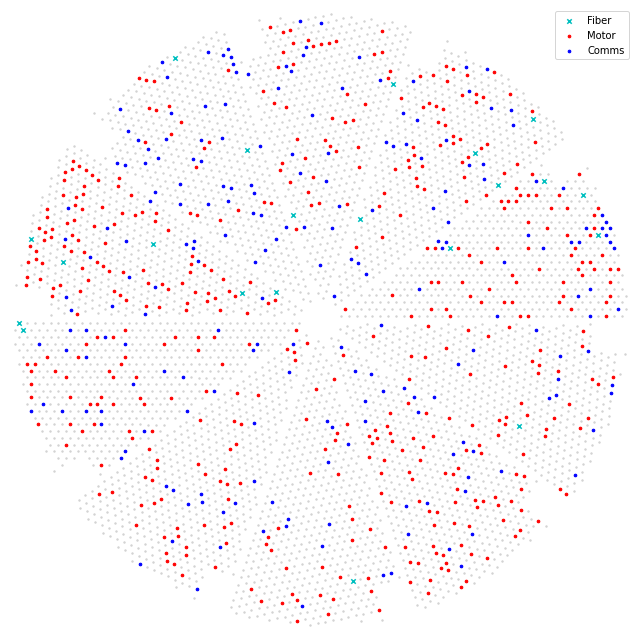

In [14]:
def plot_xy(Combined):
    
    locs = Combined.location
    badfiber = locs[~Combined.fiber_intact & Combined.in_desi]
    badmotor = locs[Combined.badmotor & Combined.in_desi]
    badcomms = locs[Combined.badcomms & Combined.in_desi]
    
    fig, ax = plt.subplots(figsize=(9, 9))
    
    plotFP(
        (None, dict(c='lightgray', s=2)),
        (badfiber, dict(c='c', marker='x', s=20, label='Fiber')),
        (badmotor, dict(c='r', s=7, label='Motor')),
        (badcomms, dict(c='b', s=7, label='Comms')),
    )
    
    plt.tight_layout()
    plt.savefig('nonfunc-xy.png')

plot_xy(Combined)

Get the history of science exposures with positioning loops:

In [15]:
def get_expinfo():
    sql = f"select id,update_time,inpos,fvctime,exptime from exposure.exposure where flavor='science' order by update_time asc"
    exps = DB.query(sql, maxrows=100000)
    sel = (exps.inpos == True) & (exps.exptime > 20)
    return exps[sel]

exps = get_expinfo()

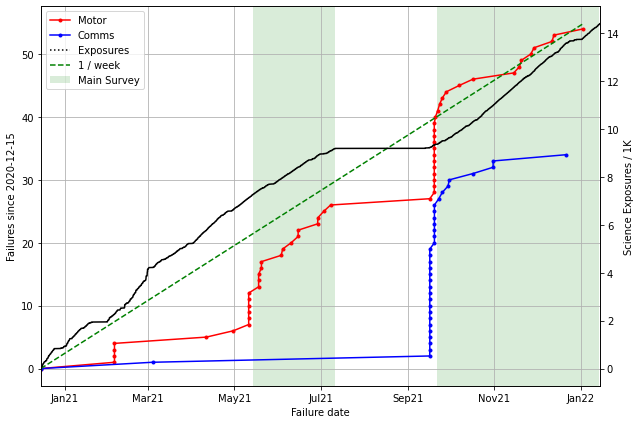

In [16]:
def plot_failures(Combined, t0='20201215'):
    
    tmotor = Combined[Combined.badmotor].calib_time.sort_values()    
    tcomms = Combined[Combined.badcomms].calib_time.sort_values()
    texps = exps.update_time.sort_values()
    tmax = texps.max()
    
    t0 = pd.Timestamp(t0, tz='UTC')
    tmotor = np.concatenate(([t0], tmotor[tmotor > t0]))
    tcomms = np.concatenate(([t0], tcomms[tcomms > t0]))
    texps = np.concatenate(([t0], texps[texps > t0]))
        
    nmotor = np.arange(0, len(tmotor))
    ncomms = np.arange(0, len(tcomms))
    nexps = np.arange(0, len(texps))
    
    fig, ax = plt.subplots(figsize=(9, 6))
    
    ax.plot(tmotor, nmotor, 'r.-', label='Motor')
    ax.plot(tcomms, ncomms, 'b.-', label='Comms')
    ax.plot([], [], 'k:', label='Exposures')
    
    rhs = ax.twinx()
    rhs.plot(texps, nexps / 1e3, 'k-')
    rhs.set_ylabel('Science Exposures / 1K')
    
    start, stop = tmotor[0],tmotor[-1]
    ndays = (stop - start).value / 86400e9
    
    rate = 1 / 7
    pred = ndays * rate
    
    ax.plot([start, stop], [0, pred], 'g--', label='1 / week')
    ax.set_xlabel('Failure date')
    ax.set_ylabel(f'Failures since {t0.date()}')
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b%y'))
    
    ax.axvspan(pd.Timestamp('20210514', tz='UTC'), pd.Timestamp('20210711', tz='UTC'), fc='green', alpha=0.15, label='Main Survey')
    ax.axvspan(pd.Timestamp('20210921', tz='UTC'), pd.Timestamp('20220114', tz='UTC'), fc='green', alpha=0.15)
    
    ax.set_xlim(t0, tmax)

    ax.legend()    
    ax.grid()
    
    plt.tight_layout()
    plt.savefig('failures.png')
    
plot_failures(Combined)

Look for trends with positioner serial number:

In [17]:
INDEX = pd.read_csv(
    DESI / 'engineering' / 'focalplane' / 'PositionerIndexTable' / 'index_files' / 'desi_positioner_indexes_20211005.csv')
INDEX['LOCATION'] = INDEX['PETAL_LOC']*1000 + INDEX['DEVICE_LOC']
INDEX.sort_values(by='LOCATION', inplace=True)

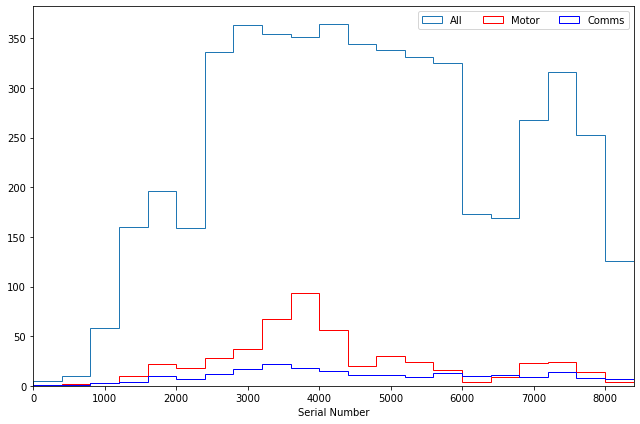

In [18]:
def plot_sn(Combined):

    bins = np.linspace(0, 8400, 22)
    sernums = lambda posids: [int(posid[1:]) for posid in posids]
    
    fig, ax = plt.subplots(figsize=(9, 6))
    
    snall = sernums(INDEX[INDEX.DEVICE_TYPE=='POS'].DEVICE_ID)
    ax.hist(snall, bins=bins, histtype='step', label='All')
    
    snmotor = sernums(list(Combined[Combined.badmotor].index))
    ax.hist(snmotor, bins=bins, histtype='step', color='r', label='Motor')

    sncomms = sernums(list(Combined[Combined.badcomms].index))
    ax.hist(sncomms, bins=bins, histtype='step', color='b', label='Comms')

    ax.set_xlabel('Serial Number')
    ax.set_xlim(bins[0], bins[-1])
    ax.legend(ncol=3)

    plt.tight_layout()
    plt.savefig('sernum.png')

plot_sn(Combined)

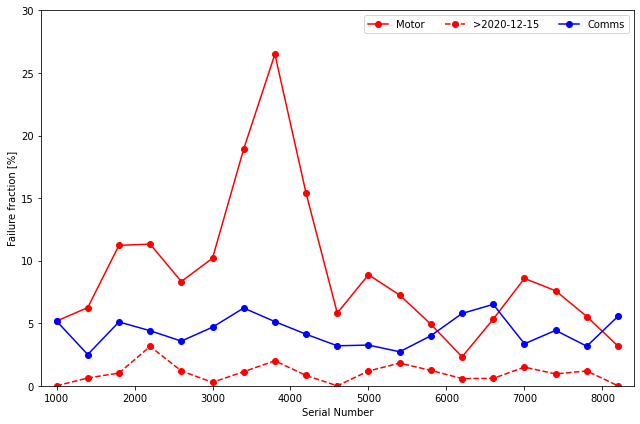

In [19]:
def plot_sn_frac(Combined, t0='20201215'):

    bins = np.linspace(800, 8400, 20)
    sernums = lambda posids: [int(posid[1:]) for posid in posids]

    t0 = pd.Timestamp(t0, tz='UTC')
    recent = Combined.calib_time > t0

    fig, ax = plt.subplots(figsize=(9, 6))
    
    snall = sernums(INDEX[INDEX.DEVICE_TYPE=='POS'].DEVICE_ID)
    snall_hist, _ = np.histogram(snall, bins=bins)
    
    snmotor = sernums(list(Combined[Combined.badmotor].index))
    snmotor_hist, _ = np.histogram(snmotor, bins=bins)
    snmotor2 = sernums(list(Combined[Combined.badmotor & recent].index))
    snmotor2_hist, _ = np.histogram(snmotor2, bins=bins)

    sncomms = sernums(list(Combined[Combined.badcomms].index))
    sncomms_hist, _ = np.histogram(sncomms, bins=bins)
    
    x = (bins[1:] + bins[:-1]) / 2
    ax.plot(x, 100 * snmotor_hist / snall_hist, 'ro-', label='Motor')
    ax.plot(x, 100 * snmotor2_hist / snall_hist, 'ro--', label=f'>{t0.date()}')
    ax.plot(x, 100 * sncomms_hist / snall_hist, 'bo-', label='Comms')

    ax.set_xlabel('Serial Number')
    ax.set_ylabel('Failure fraction [%]')
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(0, 30)
    ax.legend(ncol=3)

    plt.tight_layout()
    plt.savefig('sernum-frac.png')

plot_sn_frac(Combined)